# **Image Classification Training Pipeline with PyTorch**

This notebook demonstrates a complete pipeline for training and evaluating an image classification model using PyTorch. The pipeline includes data preparation, model creation, training, evaluation, and hyperparameter tuning. 

**Modules Imported:**
- `create_data_loaders` for data preprocessing and loading
- `create_model` for customizable ResNet model creation
- `train_model` for the training process with tracking and saving best results
- `evaluate_model` and `plot_confusion_matrix` for model evaluation
- `save_model` and `load_model` for saving and loading trained models

---

In [1]:

# Import core libraries
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import seaborn as sns
import os

# Import custom functions
from data import create_data_loaders
from model import create_model
from train import train_model
from evaluate import evaluate_model, plot_confusion_matrix
from save_model import save_model, load_model


#### Data Preparation
Use the create_data_loaders function to load and preprocess the data.



### Step-by-Step Explanation


### Check the data.py file


1. **Imports and Function Definition**:
   - The code imports necessary libraries from `torch` and `torchvision`, including modules for dataset handling, data transformation, and creating data loaders.
   - The function `create_data_loaders` is defined with parameters for the data directory, image dimensions, batch size, and split ratios for training, validation, and testing sets.

2. **Data Transformation**:
   - The `transforms.Compose` function is used to create a series of image transformations that will be applied to every image in the dataset. These transformations serve to augment and preprocess the images, improving the model's robustness. 
   
   The transformations applied are:
   - `transforms.Resize((img_height, img_width))`: Resizes images to the specified height and width.
   - `transforms.RandomRotation(15)`: Randomly rotates the image by up to 15 degrees, providing slight rotation-based augmentation.
   - `transforms.RandomHorizontalFlip()`: Randomly flips the image horizontally, helping the model learn symmetry in chess piece appearances.
   - `transforms.ColorJitter`: Adjusts brightness, contrast, saturation, and hue within specified ranges, creating slight color variations to make the model more robust to lighting changes.
   - `transforms.RandomResizedCrop`: Randomly crops a portion of the image and resizes it back to the specified dimensions. This helps the model become robust to small changes in image scale and position.
   - `transforms.ToTensor()`: Converts the PIL image to a PyTorch tensor.
   - `transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])`: Normalizes the image using mean and standard deviation values typical for pretrained models on ImageNet. This scales the pixel values to be compatible with models trained on ImageNet data.

3. **Loading the Dataset**:
   - `datasets.ImageFolder(data_dir, transform=transform)` loads images from `data_dir`, applies the defined transformations, and assigns labels based on the directory structure.
   - `ImageFolder` assumes that each subfolder within `data_dir` represents a different class, so each image is automatically assigned a label based on its subfolder.

4. **Calculating Split Sizes**:
   - The dataset is split into training, validation, and test sets based on the specified ratios (`train_split`, `val_split`, and `test_split`).
   - `train_size`, `val_size`, and `test_size` are calculated based on the total number of images in `dataset`.
   - `train_size` is the number of images in the training set, `val_size` is the number of images in the validation set, and `test_size` is the remainder, assigned to the test set.

5. **Splitting the Dataset**:
   - `random_split` is used to divide the dataset into three subsets: training, validation, and test.
   - `train_dataset`, `val_dataset`, and `test_dataset` are the resulting subsets, each containing the specified number of images.

6. **Creating Data Loaders**:
   - `DataLoader` is used to create loaders for each subset (train, val, and test), enabling batch processing and shuffling.
   - `train_loader`: Loads the training data with shuffling, which helps the model generalize better.
   - `val_loader`: Loads the validation data without shuffling, as the validation set is used to evaluate performance without introducing variability.
   - `test_loader`: Loads the test data similarly to the validation data, to evaluate the model’s final performance.
   
7. **Return the Data Loaders**:
   - The function returns the three data loaders (`train_loader`, `val_loader`, and `test_loader`), which can be used for training, validation, and testing in the main training script.

### Summary

- This data preparation function handles augmentation, normalization, and dataset splitting, enabling efficient data loading during training and evaluation.
- The use of augmentations like random rotation, flipping, color jitter, and random cropping provides variability in training data, improving the model's ability to generalize.
- The split of data into training, validation, and test sets ensures that the model can be properly evaluated on unseen data during and after training. 

#### Check Data Distribution

In [ ]:
from collections import Counter


data_dir = 'Data'
img_height, img_width = 224, 224
batch_size = 32

train_loader, val_loader, test_loader = create_data_loaders(data_dir, img_height, img_width, batch_size)

original_dataset = train_loader.dataset.dataset

# Get the class names and the number of classes
class_names = original_dataset.classes
num_classes = len(class_names)
print(f"Number of classes: {num_classes}")
print("Class names:", class_names)

# Define a helper function to count instances per class
def count_classes(data_loader):
    targets = [data_loader.dataset.dataset.targets[i] for i in data_loader.dataset.indices]
    class_counts = Counter(targets)
    total_images = len(data_loader.dataset)

    # Print the count for each class
    for class_idx, count in class_counts.items():
        print(f"{class_names[class_idx]}: {count} images")
    
    print(f"Total images: {total_images}\n")

# Print the class distribution in each dataset split
print("\nTraining set:")
count_classes(train_loader)

print("Validation set:")
count_classes(val_loader)

print("Test set:")
count_classes(test_loader)

Number of classes: 6
Class names: ['Bishop', 'King', 'Knight', 'Pawn', 'Queen', 'Rook']

Training set:
Rook: 91 images
Pawn: 99 images
King: 71 images
Bishop: 71 images
Knight: 106 images
Queen: 69 images
Total images: 507

Validation set:
Bishop: 7 images
Queen: 3 images
Pawn: 3 images
Rook: 5 images
Knight: 7 images
King: 3 images
Total images: 28

Test set:
King: 1 images
Bishop: 8 images
Rook: 6 images
Knight: 5 images
Pawn: 4 images
Queen: 5 images
Total images: 29



## Model Creation, check the model.py file

Define the model using create_model, specifying the architecture, dropout rate, and other parameters.

Here’s a detailed explanation of the `model.py` file, which defines a function to create and customize a ResNet model for image classification.

### Code Breakdown

1. **Imports**:
   - **`torch`**: PyTorch’s main library, used for building and manipulating deep learning models.
   - **`torchvision.models`**: A module within PyTorch that provides access to a set of pre-trained models, including ResNet.
   - **`torch.nn`**: A submodule that provides layers and functions for building neural networks.
   - **Specific Model Imports**:
     - **`resnet18`, `resnet34`, `resnet50`**: Imports specific ResNet model architectures.
     - **`ResNet50_Weights`**: Contains pre-trained weights for ResNet50, allowing the use of a model pre-trained on the ImageNet dataset.

2. **Function Definition: `create_model`**:
   - This function is designed to initialize and customize a ResNet model for a specific classification task.

   **Parameters**:
   - `num_classes` (default=6): Number of output classes for the classification task. For example, if we’re classifying chess pieces, `num_classes` could be set to 6 for the six types of chess pieces (e.g., Bishop, King, Knight, Pawn, Queen, Rook).
   - `dropout_rate` (default=0.5): Dropout rate for regularizing the model and reducing overfitting.
   - `model_name` (default='resnet18'): Specifies which ResNet architecture to use. The options are 'resnet18', 'resnet34', and 'resnet50'.
   - `pretrained` (default=True): If set to `True`, the model will load pre-trained weights (typically from the ImageNet dataset).
   - `num_units` (default=256): Number of units in the hidden fully connected layer (added for customization).

3. **Selecting the Model Architecture**:
   - The function first checks the `model_name` parameter to select the appropriate ResNet architecture.
   - Depending on the value of `model_name`, one of the following models is created:
     - **resnet18**: Loads ResNet-18 architecture.
     - **resnet34**: Loads ResNet-34 architecture.
     - **resnet50**: Loads ResNet-50 architecture and optionally its pre-trained weights.
   - If an invalid `model_name` is provided, it raises a `ValueError` to notify the user that only certain ResNet versions are supported.

4. **Customizing the Final Fully Connected Layer**:
   - ResNet models have a default fully connected layer (FC layer) at the end, designed to output 1,000 classes (for ImageNet).
   - **`model.fc.in_features`** retrieves the number of input features to the original FC layer.
   - The original `fc` layer is replaced with a new sequential layer comprising:
     - `nn.Linear(num_ftrs, num_units)`: A fully connected layer that reduces the input features to `num_units` (e.g., 256 units).
     - `nn.ReLU()`: A ReLU activation function, introducing non-linearity.
     - `nn.Dropout(dropout_rate)`: Dropout layer with the specified rate, helping to prevent overfitting.
     - `nn.Linear(num_units, num_classes)`: Final output layer that maps the `num_units` down to `num_classes`, making it suitable for the specific classification task.

5. **Return Statement**:
   - The function returns the customized `model`, ready to be trained or used for inference.

### Explanation of Fine-Tuning vs. Feature Extraction

In this script:
   - **Fine-tuning**: Only the final fully connected layer (`model.fc`) is replaced. However, if the model parameters were not explicitly frozen (i.e., `requires_grad = False` for the layers), the rest of the ResNet model will also be updated during training. This allows the entire model to adapt to the new task (full fine-tuning).
   - **Feature Extraction** (optional): To perform feature extraction rather than full fine-tuning, one could add code to freeze all layers except the new fully connected layer, like this:
     ```python
     for param in model.parameters():
         param.requires_grad = False
     ```
   This would mean only the new `fc` layer will be trained, treating the rest of ResNet as a fixed feature extractor.

### Summary

- This script is designed to create a customized ResNet model, with options for different ResNet architectures (`resnet18`, `resnet34`, or `resnet50`) and using pre-trained weights if desired.
- The function replaces the final fully connected layer with a new one tailored for the specified number of classes and with a specified hidden layer size and dropout rate.
- By default, this setup allows for **fine-tuning** of the ResNet model (all layers are trainable), but can easily be modified for **feature extraction** by freezing earlier layers.

In [3]:
# Model parameters
dropout_rate = 0.5
model_name = 'resnet50'
pretrained = True
num_units = 256

# Instantiate the model
model = create_model(num_classes=num_classes, dropout_rate=dropout_rate, model_name=model_name, pretrained=pretrained, num_units=num_units)

# Display model summary
print("Model Architecture:")
print(model)

Model Architecture:
ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size

#### Model Training with Visualizations
Train the model using train_model, while capturing training and validation metrics for visual analysis. We’ll plot the loss and accuracy curves at the end of training to observe the learning process.

In [9]:
import torch

model = create_model(num_classes=6, model_name="resnet50", num_units=144)
model.load_state_dict(torch.load("models/chess_classifier.pth"))
model.eval()

C:\Users\Anthony Soronnadi\AppData\Local\Temp\ipykernel_2184\566133319.py:4: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("models/chess_cla

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

## Hyperparameter Search

Here’s an explanation of the `hyperparameter_search.py` script. This script uses Optuna, a hyperparameter optimization framework, to perform automated hyperparameter tuning for a model.

### Code Explanation

1. **Imports**:
   - **`optuna`**: An optimization library for automated hyperparameter tuning. 
   - **`torch`**: The core PyTorch library for deep learning.
   - **`yaml`**: Allows saving and loading configuration files in a human-readable format (YAML).
   - **`argparse`**: For handling command-line arguments.
   - **Custom Modules**:
     - `create_data_loaders` (from `data`): Function to load and preprocess the dataset.
     - `create_model` (from `model`): Function to initialize the model.
     - `train_model` (from `train`): Function to train the model and return validation accuracy.

2. **Objective Function** (`objective`):
   - This function defines the hyperparameter search space and returns the validation accuracy for each set of hyperparameters. It serves as the optimization target for Optuna.
   - **Parameters**:
     - `trial`: The Optuna trial object used to suggest hyperparameters.
     - `data_dir`, `img_height`, `img_width`, and `epochs`: Additional parameters to specify dataset details and training duration.
   - **Hyperparameter Suggestions**:
     - **`learning_rate`**: Suggested on a logarithmic scale between \(10^{-5}\) and \(10^{-2}\).
     - **`dropout_rate`**: Suggested on a linear scale between 0.2 and 0.5.
     - **`batch_size`**: Suggested from a discrete set of values: 16, 32, or 64.
   - **Data Preparation**:
     - The `create_data_loaders` function is called to create the data loaders with the specified `batch_size`.
   - **Model Initialization**:
     - The model is created with `create_model`, using the specified `dropout_rate` and number of classes in the dataset.
   - **Training**:
     - The model is trained using `train_model` with the suggested `learning_rate` and other hyperparameters.
     - **Validation Accuracy**: This is returned as the objective metric for Optuna to maximize.

3. **Main Functionality** (`__main__`):
   - **Argument Parsing**:
     - Arguments include the `data_dir` for the dataset, `img_height` and `img_width` for resizing, and `epochs` for training.
   - **Creating an Optuna Study**:
     - **`optuna.create_study`**: Initializes a study to maximize validation accuracy, with a random sampling strategy (`RandomSampler`).
     - **`study.optimize`**: The `objective` function is optimized over a specified number of trials (`n_trials=10`).
   - **Best Hyperparameters**:
     - Once the trials complete, the best hyperparameters are retrieved using `study.best_params`.
   - **Saving the Best Hyperparameters**:
     - The best parameters are saved to `best_hyperparameters.yaml` for later use, making it easy to apply the optimal configuration without repeating the search.

### Key Components Explained

- **Optuna**: This library is used for hyperparameter optimization, which systematically searches through the specified hyperparameter space and tries to maximize the validation accuracy.
- **Objective Function**: The `objective` function defines the hyperparameter space and trains the model with the given parameters for each trial. This function is optimized by Optuna.
- **Hyperparameter Suggestions**:
  - **`learning_rate`**: Optuna samples this on a log scale to ensure a wide range of potential values for fine-tuning the model’s learning pace.
  - **`dropout_rate`**: Controls the dropout for regularization, helping to avoid overfitting by randomly deactivating neurons during training.
  - **`batch_size`**: The size of data batches can affect training speed and stability, so Optuna samples from common values.
- **Saving Results**: Saving the best hyperparameters to a YAML file allows these to be reused or referenced without rerunning the optimization process.

### Example Usage

To perform a hyperparameter search with this script:
```bash
python hyperparameter_search.py --data_dir path/to/data --img_height 224 --img_width 224 --epochs 10
```

This command will run the script for 10 epochs per trial, using the specified dataset and image dimensions.

### Summary

The `hyperparameter_search.py` script is designed for efficient and systematic hyperparameter tuning:
- It uses Optuna to automatically search for optimal values for `learning_rate`, `dropout_rate`, and `batch_size`.
- After several trials, it identifies the best combination and saves it for easy reuse.
- This approach improves the model’s performance by systematically exploring the hyperparameter space, rather than manually testing different configurations. 

This setup can save time, enhance model performance, and ensure a reproducible configuration for future model training.

## Model Training

A detailed breakdown of `train.py`, which defines the `train_model` function for training a neural network model on our dataset.

### Code Explanation

1. **Imports**:
   - **`torch`**: The main PyTorch library for tensor operations and deep learning.
   - **`torch.optim`**: Provides optimization algorithms, such as `Adam`.
   - **`torch.nn`**: Contains neural network layers and loss functions. Here, we’re using `nn.CrossEntropyLoss` for classification.
   - **`evaluate`**: Imports a custom function `evaluate_model` for evaluating the model on a validation set.
   - **`ReduceLROnPlateau`**: A learning rate scheduler that reduces the learning rate if the validation loss plateaus, improving training stability.
   - **`json`**: Used to save the training history as a JSON file for later analysis.

2. **Function Definition: `train_model`**:
   - **Parameters**:
     - `model`: The PyTorch model to be trained.
     - `train_loader`: DataLoader for the training set.
     - `val_loader`: DataLoader for the validation set.
     - `epochs`: The number of training epochs.
     - `learning_rate`: The learning rate for the optimizer.
     - `device`: The device (CPU or GPU) on which to perform training.
     - `save_model` (default=True): Whether to save the best model based on validation loss.

3. **Loss, Optimizer, and Scheduler Initialization**:
   - **Criterion**: `nn.CrossEntropyLoss` is used as the loss function for multi-class classification.
   - **Optimizer**: Uses `Adam` optimizer, but only for the final fully connected (`fc`) layer, to reduce computation. This suggests the rest of the model is pre-trained and is being used as a feature extractor.
   - **Scheduler**: `ReduceLROnPlateau` reduces the learning rate when validation loss stops improving for a few epochs (set by `patience`). This helps the model converge more effectively.

4. **Model Setup and Training History**:
   - Moves the model to the specified `device`.
   - Initializes `history` dictionary to track `accuracy`, `val_accuracy`, `loss`, and `val_loss` across epochs.
   - `best_val_loss` is initialized to infinity to store the best validation loss, while `patience` variables are used for early stopping.

5. **Training Loop**:
   - The training loop iterates over the specified number of `epochs`.
   - **Training Phase**:
     - Sets the model to `train()` mode, enabling training-specific operations like dropout.
     - For each batch in `train_loader`:
       - Moves `images` and `labels` to `device`.
       - Clears the gradients (`optimizer.zero_grad()`), performs a forward pass, computes loss, and backpropagates (`loss.backward()`).
       - **Parameter Update**: `optimizer.step()` updates model weights based on gradients.
       - **Metrics Calculation**: Accumulates training loss, counts correct predictions, and calculates training accuracy.
   - **Validation Phase**:
     - Calls `evaluate_model` (external function) to compute validation loss and accuracy. If an error occurs during validation, it defaults to `inf` for `val_loss` and 0 for `val_accuracy`.
     - Updates the scheduler with the validation loss.
     - **Checkpointing**: If `val_loss` improves, saves the model as `best_model.pth` and resets `patience`. Otherwise, increments `patience`. If `patience` exceeds `patience_limit`, stops training early.

6. **Logging**:
   - After each epoch, logs the training and validation metrics.
   - If `save_model` is `True`, prints confirmation of saving the best model.

7. **Training History**:
   - Saves `history` to a JSON file, `training_history.json`, for later analysis or visualization.

8. **Return Statement**:
   - Returns the `history` dictionary, containing metrics tracked during training, which can be used to plot or further analyze the model’s performance.

### Key Components Explained

- **Early Stopping**: Stops training if the model hasn't improved on validation loss for a certain number of epochs (`patience_limit`), helping to prevent overfitting.
- **Learning Rate Scheduler**: `ReduceLROnPlateau` reduces the learning rate when validation loss plateaus, allowing for finer adjustments to the model as it converges.
- **Saving Model and History**: Saves the model's weights whenever validation loss improves, ensuring the best version of the model is retained. The `history` is saved to a JSON file for easy access and analysis outside the training script.

### Summary

The `train.py` script provides a robust and flexible framework for training a PyTorch model. It includes:
- Detailed tracking of training and validation metrics,
- Automatic saving of the best model,
- Learning rate scheduling and early stopping to enhance convergence,
- Validation steps within each epoch, with error handling for robustness,
- Saving training history for future analysis. 

### Evaluation

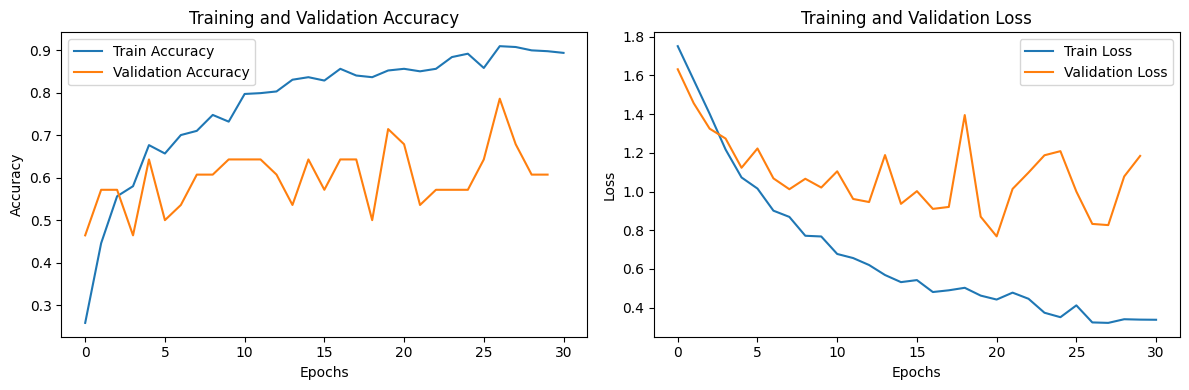

In [ ]:
import json
import matplotlib.pyplot as plt

# Load history
with open("training_history.json", "r") as f:
    history = json.load(f)

import matplotlib.pyplot as plt


train_accuracy = [acc / 100 for acc in history['accuracy']]
val_accuracy = history['val_accuracy']

plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(train_accuracy, label='Train Accuracy')
plt.plot(val_accuracy, label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history['loss'], label='Train Loss')
plt.plot(history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()


C:\Users\Anthony Soronnadi\AppData\Local\Temp\ipykernel_2184\1760042842.py:13: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('models/chess_c

Validation Loss: 0.3123
Accuracy: 0.8966, Precision: 0.9034, Recall: 0.8966, F1-score: 0.8971
Test Loss: 0.3123
Test Accuracy: 0.8966
Test Precision: 0.9034
Test Recall: 0.8966
Test F1-score: 0.8971


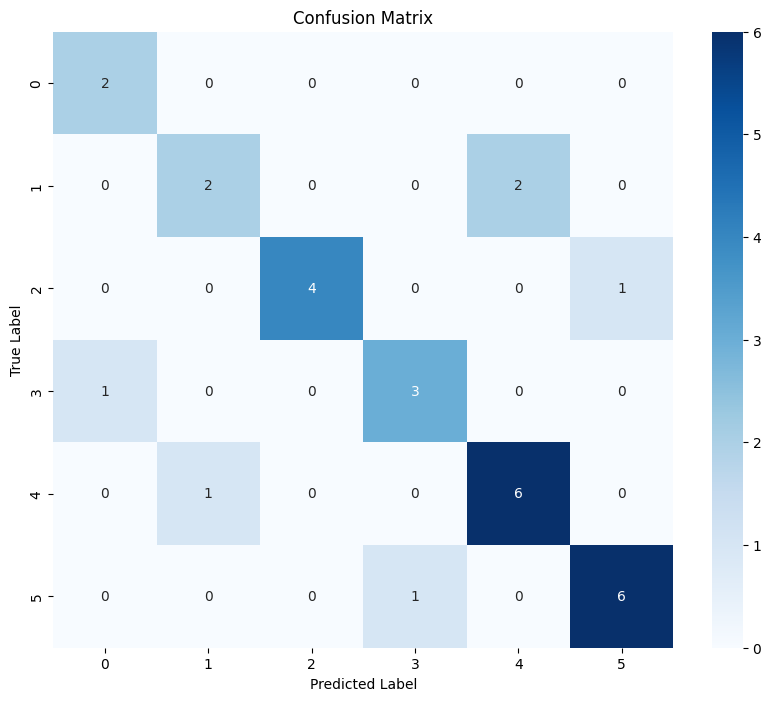

In [15]:
# Import necessary modules
import torch
import torch.nn as nn
from evaluate import evaluate_model, plot_confusion_matrix  # Import the functions
from data import create_data_loaders  # Import your data loader function to load the test data
from model import create_model  # Import your model creation function

# Load the trained model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = create_model(num_classes=6, model_name='resnet50', num_units=144)  # Specify the number of classes and model name

# Load the model's weights
model.load_state_dict(torch.load('models/chess_classifier.pth', map_location=device))
model.to(device)

# Load the test dataset
data_dir = 'Data'  # Update to the correct path if necessary
img_height, img_width = 224, 224
batch_size = 32
_, _, test_loader = create_data_loaders(data_dir, img_height, img_width, batch_size)

# Define the loss criterion
criterion = nn.CrossEntropyLoss()

# Evaluate the model on the test dataset
test_loss, test_accuracy, test_precision, test_recall, test_f1 = evaluate_model(model, test_loader, device, criterion)

# Print the evaluation results
print(f"Test Loss: {test_loss:.4f}")
print(f"Test Accuracy: {test_accuracy:.4f}")
print(f"Test Precision: {test_precision:.4f}")
print(f"Test Recall: {test_recall:.4f}")
print(f"Test F1-score: {test_f1:.4f}")

# Plot the confusion matrix
plot_confusion_matrix(model, test_loader, device, save_path='plots/confusion_matrix.png')

### API Call

In [ ]:
import requests
from PIL import Image

file_path = r"image-test.png"  

try:
    with Image.open(file_path) as img:
        print("Image format:", img.format) 
        if img.format not in ["JPEG", "PNG"]:
            raise ValueError("Invalid image format. Please use a JPEG or PNG file.")
except Exception as e:
    print(f"Image format check failed: {e}")
    exit() 

# Define the API endpoint
url = "http://127.0.0.1:8000/predict"

try:
    with open(file_path, "rb") as image_file:
        files = {"file": (file_path, image_file, "image/jpeg")} 
        response = requests.post(url, files=files)
        print("Response:", response.json())
except Exception as e:
    print(f"Request failed: {e}")


Image format: PNG
Response: {'class_label': 'Knight', 'confidence': 0.9992715716362}
